# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: Javier Martinez Velasco

**Matricola**: 2058968


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.image import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D,MaxPooling2D,Input
from tensorflow.keras.layers import Dropout,Conv2D,Flatten,BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.datasets import cifar100
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
# non tf libraries were used for data split, plots and obtain performance stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import time

In [4]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Warmup: Data loading




**Task Description and Motivation**  

There would be two main steps during the homework:

*   Train from scratch a Convolutional Neural Network (**CNN**), such that is suited for binary classification on the `cats_vs_dogs` dataset (dataset details below). The original images have all different shapes, so have been resaphed to be 64x64.
*   Perform Parameter Efficient Fine-Tuning (**PEFT**) on this trained CNN, by using Low-Rank Adaptation (**LoRA**) on the `leopards_vs_wolfs` dataset (details below). The images are 32x32 and resaphed to be 64x64.

The main assumption of this fine-tuning task is based on the fact that both cats and leopards, as well as dogs and wolfs, belong to the same animal families of species ([Felidae](https://it.wikipedia.org/wiki/Felidae) and [Canidae](https://it.wikipedia.org/wiki/Canidae)
respectively). Therefore I assumed that due to their shared biological traits, a model that was trained using cats and dogs data; could be also used to achieve good performance on distinguising between leopards and wolfs, by performing PEFT to the original model through LoRA.


**Dataset Description** <br>

For this homework, I will be using two well-known image classification datasets:

*   **TensorFlow Dataset** [`cats_vs_dogs`](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs). Data Size: about 12K images per animal (around 24K images in total), from which 80% are used for training, 10% for validating during training and 10% for final testing.
*   Subset of **TensorFlow Dataset** [`CIFAR100`](https://www.tensorflow.org/datasets/catalog/cifar100) considering only classes 42 (**leopard**) and 97 (**wolf**). From here onwords I will refer to this dataset as `leopards_vs_wolfs`. Data Size: 600 images for each animal (1200 images in total) from which 80% are used for training, 10% for validating during training and 10% for final testing. The images are 32x32 and have been augmented to be 64x64.

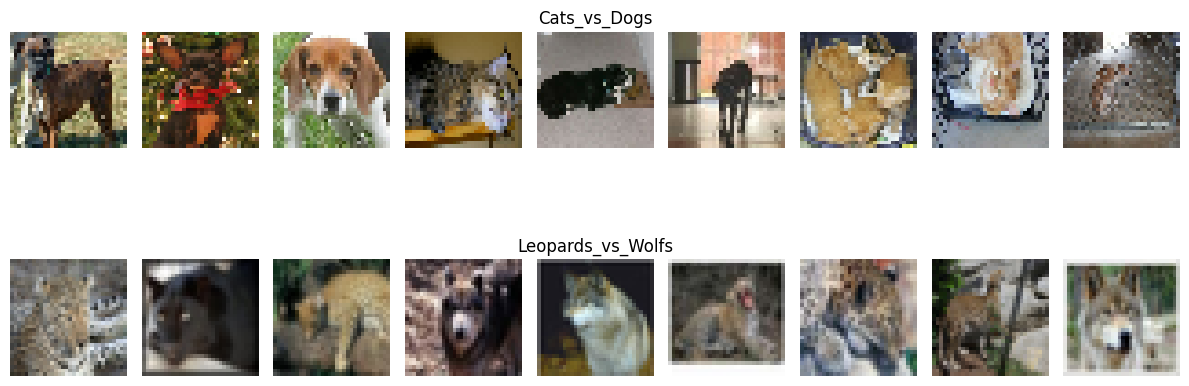

In [26]:
## Loading cats_vs_dogs data and preprocessing it

def resize_image(image, label, img_size=(64, 64)):
    """
    Resize and normalize an image.
    """
    image_resized = tf.image.resize(image, img_size)
    image_resized = tf.cast(image_resized, tf.float32) / 255.0
    return image_resized, label

import tensorflow as tf
import tensorflow_datasets as tfds

def resize_image(image, label):
    # Resize images to a fixed size, e.g., 64x64
    image = tf.image.resize(image, [64, 64])
    # Normalize pixel values to [0, 1]
    image = image / 255.0
    return image, label

def load_and_preprocess_cats_vs_dogs(buffer_size=1000, batch_size=32):
    """
    Load the cats_vs_dogs dataset from TensorFlow Datasets, preprocess it,
    and split into training, validation, and test datasets.
    """
    # Load the dataset
    (ds_train, ds_val, ds_test), ds_info = tfds.load(
        'cats_vs_dogs',
        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],  # 80% training, 10% validation, 10% test
        as_supervised=True,
        with_info=True)

    # Apply preprocessing to datasets using map function
    ds_train = ds_train.map(lambda image, label: resize_image(image, label),
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_val = ds_val.map(lambda image, label: resize_image(image, label),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds_test = ds_test.map(lambda image, label: resize_image(image, label),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Shuffle, batch, and prefetch datasets
    ds_train = ds_train.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    ds_val = ds_val.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return ds_train, ds_val, ds_test

# Example usage
ds_train, ds_val, ds_test = load_and_preprocess_cats_vs_dogs()

## Loading leopards_vs_wofs data and preprocessing it

def load_resize_cifar100():
    # Load CIFAR-100 dataset
    (x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar100.load_data()

    # Find numerical labels for 'wolf' and 'leopard' in CIFAR-100
    leopard_label = 42  # 'leopard' label in CIFAR-100
    wolf_label = 97  # 'wolf' label in CIFAR-100

    # Filter and gather indices for training data
    train_indices = tf.where(tf.logical_or(tf.equal(y_train, leopard_label),
                                           tf.equal(y_train, wolf_label)))[:, 0]
    x_train_filtered = tf.gather(x_train, train_indices)
    y_train_filtered = tf.gather(y_train, train_indices)

    # Replace labels: 97 -> 1 and 42 -> 0
    y_train_filtered = tf.where(y_train_filtered == wolf_label, 1, 0)

    # Filter and gather indices for test data
    test_indices = tf.where(tf.logical_or(tf.equal(y_test, leopard_label),
                                          tf.equal(y_test, wolf_label)))[:, 0]
    x_test_filtered = tf.gather(x_test, test_indices)
    y_test_filtered = tf.gather(y_test, test_indices)

    # Replace labels: 97 -> 1 and 42 -> 0
    y_test_filtered = tf.where(y_test_filtered == wolf_label, 1, 0)

    # Combine the filtered train and test sets for splitting
    x_comb = tf.concat([x_train_filtered, x_test_filtered], axis=0)
    y_comb = tf.concat([y_train_filtered, y_test_filtered], axis=0)

    # Split the data into training (80%), validation (10%), and test (10%) sets
    x_train, x_temp, y_train, y_temp = train_test_split(x_comb.numpy(),
                                                        y_comb.numpy(),
                                                        test_size=0.2,
                                                        stratify=y_comb.numpy())
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp,
                                                    test_size=0.5,
                                                    stratify=y_temp)

    # Resize images to 64x64
    x_train_resized = tf.image.resize(x_train, [64, 64]).numpy()
    x_val_resized = tf.image.resize(x_val, [64, 64]).numpy()
    x_test_resized = tf.image.resize(x_test, [64, 64]).numpy()

    # Normalize pixel values to [0, 1]
    x_train = x_train_resized / 255.0
    x_val = x_val_resized / 255.0
    x_test = x_test_resized / 255.0

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Example usage
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_resize_cifar100()

### Exercise 1: Advanced transfer learning (10 points)


Instead of using a common family of models like VGG or ResNet, I was inspired by a simpler model that I found in this [Kaggle notebook](https://www.kaggle.com/code/kanishanand/dogs-vs-cats), which for this task I thought it was complex enough (12M trainable parameters) to justify the use of LoRA.

This convolutional neural network (CNN) is designed for binary classification. It starts with an input layer for 64×64×3 images, followed by four convolutional blocks. Each block includes a convolutional layer with ReLU activation and padding, batch normalization, max pooling to reduce spatial dimensions, and dropout to prevent overfitting. After the convolutional blocks, the network has a flatten layer, a fully connected layer with 512 neurons and ReLU activation, followed by batch normalization and dropout. The output layer is a single neuron with a sigmoid activation function, suitable for binary classification.

In [43]:
# Define the model
regularization = tf.keras.regularizers.L2(l2=0.001)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same",
           input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.26),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.26),
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.26),
    Conv2D(128, (3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.26),
    Flatten(),
    Dense(512, activation='relu',kernel_regularizer=regularization),
    BatchNormalization(),
    Dropout(0.26),
    Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
])

# Create some metrics to visualize them after training
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',f1_m,precision_m,recall_m])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_22 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_23 (Ba  (None, 32, 32, 64)       

In [44]:
# Train the model with validation data

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)
callbacks = [learning_rate_reduction]

# Start the timer
start_time = time.time()

history = model.fit(
    ds_train,
    epochs=15,
    validation_data=ds_test,
    callbacks = callbacks)

end_time = time.time()
elapsed_time = end_time - start_time

# evaluate the model
print(f"Time taken to run the code: {elapsed_time:.4f} seconds")

Epoch 1/15
582/582 [==============================] - 31s 46ms/step - loss: 1.2633 - accuracy: 0.6598 - f1_m: 0.6485 - precision_m: 0.6637 - recall_m: 0.6497 - val_loss: 0.9484 - val_accuracy: 0.7016 - val_f1_m: 0.6844 - val_precision_m: 0.7100 - val_recall_m: 0.6731 - lr: 0.0010
Epoch 2/15
582/582 [==============================] - 27s 45ms/step - loss: 0.7738 - accuracy: 0.7416 - f1_m: 0.7312 - precision_m: 0.7486 - recall_m: 0.7316 - val_loss: 0.7118 - val_accuracy: 0.7206 - val_f1_m: 0.7619 - val_precision_m: 0.6583 - val_recall_m: 0.9180 - lr: 0.0010
Epoch 3/15
582/582 [==============================] - 26s 43ms/step - loss: 0.5855 - accuracy: 0.7894 - f1_m: 0.7832 - precision_m: 0.7939 - recall_m: 0.7872 - val_loss: 0.5364 - val_accuracy: 0.8040 - val_f1_m: 0.8038 - val_precision_m: 0.7948 - val_recall_m: 0.8231 - lr: 0.0010
Epoch 4/15
582/582 [==============================] - 25s 41ms/step - loss: 0.5038 - accuracy: 0.8127 - f1_m: 0.8084 - precision_m: 0.8123 - recall_m: 0.8183

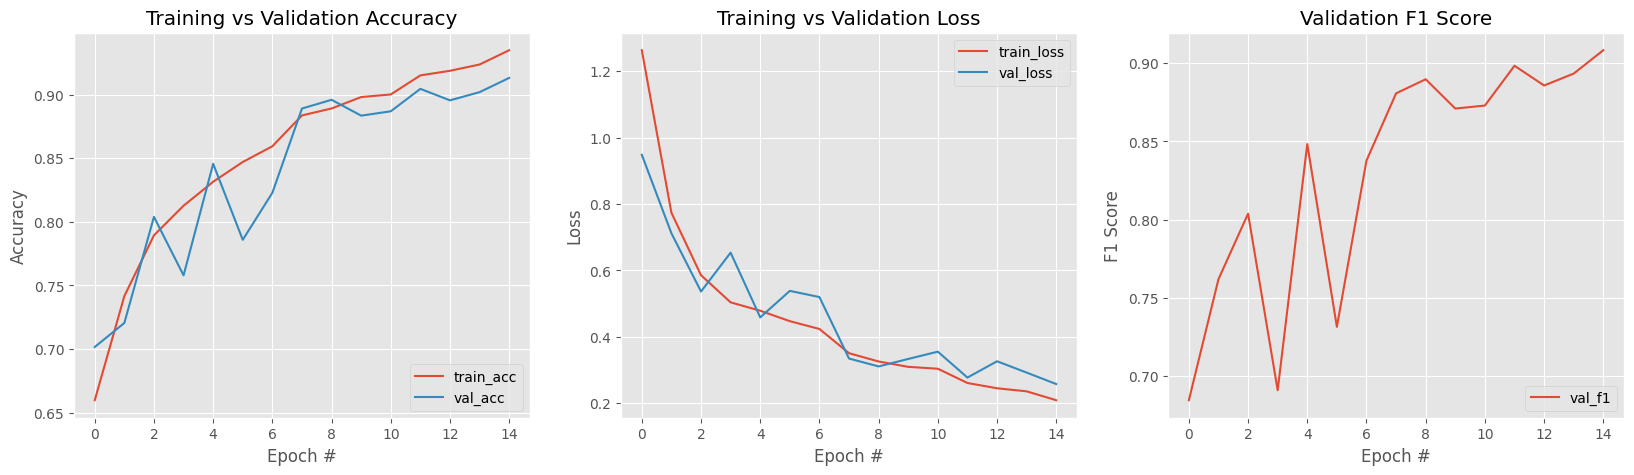

In [45]:
def plot_train_val_metrics(n, history):
    plt.style.use("ggplot")
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Extract metrics from history
    train_acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    val_f1 = history.history["val_f1_m"]

    # Plot train and validation accuracy
    axs[0].plot(np.arange(0, n), train_acc, label="train_acc")
    axs[0].plot(np.arange(0, n), val_acc, label="val_acc")
    axs[0].set_title("Training vs Validation Accuracy")
    axs[0].set_xlabel("Epoch #")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")

    # Plot train and validation loss
    axs[1].plot(np.arange(0, n), train_loss, label="train_loss")
    axs[1].plot(np.arange(0, n), val_loss, label="val_loss")
    axs[1].set_title("Training vs Validation Loss")
    axs[1].set_xlabel("Epoch #")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")

    # Plot validation F1 score
    axs[2].plot(np.arange(0, n), val_f1, label="val_f1")
    axs[2].set_title("Validation F1 Score")
    axs[2].set_xlabel("Epoch #")
    axs[2].set_ylabel("F1 Score")
    axs[2].legend(loc="lower right")

    plt.show()

# Example usage
N = 15
plot_train_val_metrics(N, history)

Let's verify the model metrics on a test set

In [47]:
def evaluate_model_on_test_set(model_, test_x,test_y):
    # Evaluate the model on the test set
    if test_y is not None:
      loss,accuracy,f1_score,precision,recall = model_.evaluate(test_x,test_y,
                                                                verbose=0)
    else:
      loss,accuracy,f1_score,precision,recall = model_.evaluate(test_x,
                                                                verbose=0)
    metrics = {
        "Loss": loss,
        "Accuracy": accuracy,
        "F1 Score": f1_score,
        "Precision": precision,
        "Recall": recall}
    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame([metrics])

    return metrics_df

metrics_df = evaluate_model_on_test_set(model, ds_test)
display(metrics_df)

,Loss,Accuracy,F1 Score,Precision,Recall
0,0.257607,0.913156,0.908346,0.932183,0.890038


After the succesful training of the model, the next step will be to introduce a LoRA layer to efficiently reduce the number of parameter updates in the model's dense layer (1049088 params.) while maintaining the model's performance. This is done by replacing the model's dense layer with a LoRA layer. Given the original weight matrix (2048 x 512) I choose as hyperparameters:

*   Rank=8, which seems to have captured the essential structures of the data without excessive complexity.
*   Alpha=8, having rank=alpha ensures moderate regularization (a sparse solution) while maintaining interpretability and practical feasibility in computation.

As a quick overview of the method, Low-Rank Adaptation (LoRA) main goal is to decompose the weight matrix $W$ of a dense layer into two smaller matrices, $W_{\text{a}}$ and $W_{\text{b}}$, such that:
$$
W \approx \alpha \cdot (W_{\text{a}} \cdot W_{\text{b}})
$$
where $\alpha$ is a scaling factor, $W_{\text{a}}$ is of shape $(d, r)$, and $W_{\text{b}}$ is of shape $(r, k)$, with $r$ being the rank, and $d$ and $k$ being the dimensions of the input and output, respectively.


In [48]:
# Define the LoRALayer

class LoRALayer(tf.keras.layers.Layer):

    """
    This class inherits from tf.keras.layers.Layer to create a LoraLayer object
    """
    def __init__(self, units, rank=1, alpha=1.0, original_weights=None, **kwargs):
        super(LoRALayer, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.alpha = alpha
        self.original_weights = original_weights

    def build(self, input_shape):
        input_dim = int(input_shape[-1])

        # Initialize LoRA matrices
        self.W_a = self.add_weight(
            shape=(input_dim, self.rank),
            initializer= tf.keras.initializers.VarianceScaling(
                    scale=math.sqrt(5), mode="fan_in", distribution="uniform"),
            trainable=True,
            name='W_a'
        )
        self.W_b = self.add_weight(
            shape=(self.rank, self.units),
            initializer="zeros",
            trainable=True,
            name='W_b'
        )

        # Initialize original weights if provided and freeze in training
        if self.original_weights is not None:
            self.original_W, self.original_b = self.original_weights
            self.original_W = tf.Variable(self.original_W, trainable=False, name='original_W')
            self.original_b = tf.Variable(self.original_b, trainable=False, name='original_b')

        # Scale factor to maintain the learning rate
        self.scale = self.alpha / self.rank

    def call(self, inputs):
        # Perform the LoRA forward pass
        lora_output = self.scale * tf.matmul(tf.matmul(inputs, self.W_a), self.W_b)
        if self.original_weights is not None:
            lora_output += tf.matmul(inputs, self.original_W) + self.original_b
        return lora_output


##### Adding a LoraLayer to our Original model

# Extract weights of the dense layer to be later added in the Lora Layer
dense_layer1_weights = model.layers[-4].get_weights()

# Define the new model by concatenating the layers (with weights) of the,
# orignal model, but only until reaching the Dense layer (model.layers[:-4]),
# which we don't add yet since is gonna become the LoraLayer in the next step

input_layer = Input(shape=(64, 64, 3))
x = input_layer
for layer in model.layers[:-4]:
    x = layer(x)

# Now I replace the dense layer with LoRALayer and add the final layers (and
#  weights) as they were in the original model

x = LoRALayer(units=512, rank=8, alpha=8.0, original_weights=dense_layer1_weights)(x)
x = tf.keras.layers.ReLU()(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
output_layer = model.layers[-1](x)
# Finish creating the new model
new_model = Model(inputs=input_layer, outputs=output_layer)

# Freeze for traning all layers before LoraLayer
for layer in new_model.layers[:-5]:
    layer.trainable = False

# Compile the new model
new_model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy',f1_m,precision_m,recall_m])

new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_22 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 64)        1849

The last step includes the actual training (fine-tuning) of the original model with the added LoRALayer.

In [49]:
# Fit the model
start_time = time.time()
history_2 = new_model.fit(x_train, y_train,
          epochs=50,
          batch_size=64,
          validation_data=(x_val, y_val))
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken to run the code: {elapsed_time:.4f} seconds")

Epoch 1/50
15/15 [==============================] - 3s 49ms/step - loss: 1.7220 - accuracy: 0.4385 - f1_m: 0.4170 - precision_m: 0.4320 - recall_m: 0.4063 - val_loss: 2.6637 - val_accuracy: 0.4833 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 16ms/step - loss: 0.9497 - accuracy: 0.5771 - f1_m: 0.5699 - precision_m: 0.5789 - recall_m: 0.5718 - val_loss: 0.7934 - val_accuracy: 0.5750 - val_f1_m: 0.6550 - val_precision_m: 0.5379 - val_recall_m: 0.8508
Epoch 3/50
15/15 [==============================] - 0s 11ms/step - loss: 0.5418 - accuracy: 0.7677 - f1_m: 0.7699 - precision_m: 0.7604 - recall_m: 0.7845 - val_loss: 1.4308 - val_accuracy: 0.5083 - val_f1_m: 0.6612 - val_precision_m: 0.4982 - val_recall_m: 1.0000
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 0.4632 - accuracy: 0.8062 - f1_m: 0.8085 - precision_m: 0.7997 - recall_m: 0.8211 - val_loss: 1.2513 - val_accuracy: 0.5

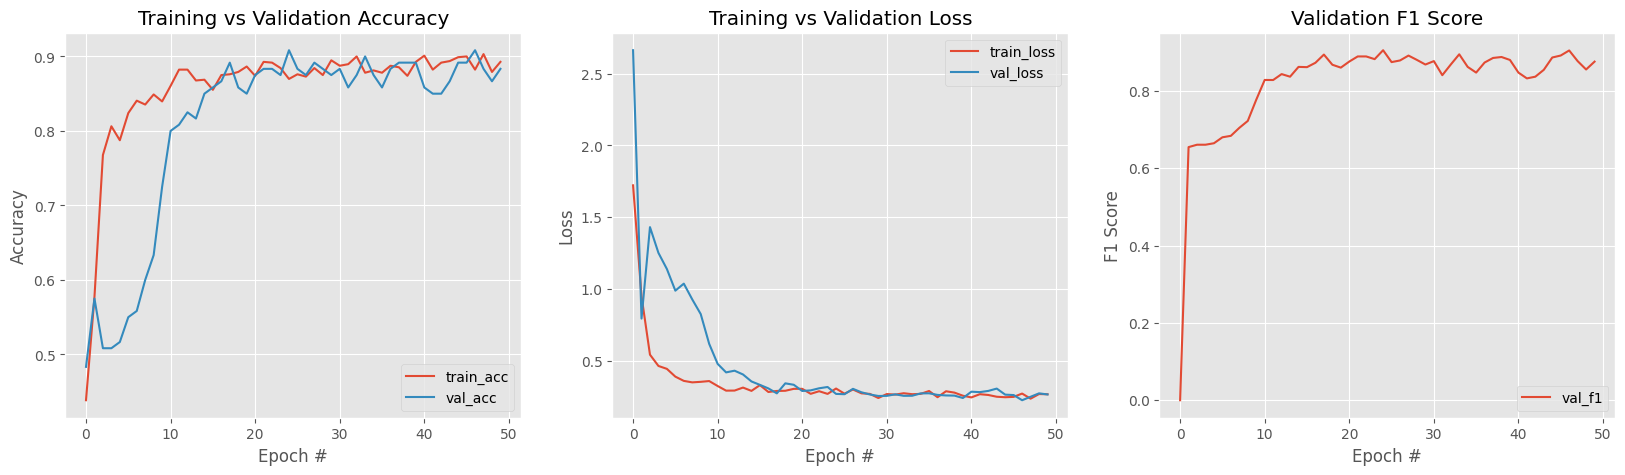

In [50]:
# PLot the train vs val accuracy scores to verify that model is not overfitting
N = 50
plot_train_val_metrics(N, history_2)

In [55]:
metrics_df = evaluate_model_on_test_set(new_model, x_test,y_test)
display(metrics_df)

,Loss,Accuracy,F1 Score,Precision,Recall
0,0.28791,0.9,0.900359,0.899702,0.902083


After performin efficient fine-tuning, we **mantain the average accuracy of around 90%** on the test set, while **only the 5% of the total data was of Leopards and Wolfs**, showing in this way how the fine-tuned model actually had already learned from the original model. In general, all metrics show correct generalization capabilities in the test data.